# <a id='toc1_'></a>[Sensitivity by individual PLP](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Sensitivity by individual PLP](#toc1_)    
  - [Summary](#toc1_1_)    
  - [Split and filter data](#toc1_2_)    
    - [QC: sample dropouts (no infected cells)](#toc1_2_1_)    
    - [Summarize spots per (infected) cell](#toc1_2_2_)    
    - [QC distribution of number of infected cells](#toc1_2_3_)    
    - [QC spot count outliers (failed segmentation):](#toc1_2_4_)    
  - [Spots per (infected) cell](#toc1_3_)    
    - [QC consistency across replicates](#toc1_3_1_)    
  - [Median spot intensity](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Summary](#toc0_)

The following settings are used:
- only spots from infected cells (at least 5 spots), discarding all other spots - exception: negative controls (cells are not infected so we keep all spots)
- include spots from the cytoplasm and the nucleus
- include inner cells and border cells in the analysis
- do not crop images (neighboring fields of view have a slight overlap so counts from these FOVs are not completely independent, this could be problematic for statistical tests (not performed here))

General observations:
- different PLPs have different sensitivity in terms of spot counts
- there is no apparent correlation between spots per infected cells and median spot intensity


In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 4)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

In [3]:
spots <- read_tsv("analysis/spot_detection/plp_individual/all_spots.tsv.xz", na="")

Rows: 965724 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): rep, segment, sample, fov
dbl (17): intensity, z, y, x, radius, spot_id, z_min, z_max, y_min, y_max, x...
lgl  (2): nucleus, border_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## <a id='toc1_2_'></a>[Split and filter data](#toc0_)

For negative controls, all spots are used and the number of spots per cell is calculated. For all other samples, only spots from *infected* cells are used and the number of spots per infected cell is calculated.
A cell is defined as *infected* if at least 5 spots are assigned to that cell, including the nucleus.


In [4]:
pos_spots <- spots %>%
  filter(!str_detect(sample, "Neg")) %>%
  group_by(rep, segment, sample, fov, cell) %>%
  filter(n() >= 5) %>%
  group_by(rep, segment, sample, fov) %>%
  mutate(infected_cells = n_distinct(cell))

In [5]:
neg_spots <- spots %>%
  filter(str_detect(sample, "Neg"))

### <a id='toc1_2_1_'></a>[QC: sample dropouts (no infected cells)](#toc0_)

After filtering cells with less than 5 spots, some samples are lost as they don't contain any infected cells.

In particular 9PLP of HA is affected. Almost all FOVs are lost, it seems like this PLP is particularly inefficient.

In [6]:
get_fovs <- . %>% ungroup %>% select(rep,segment,sample,fov) %>% unique

In [7]:
fovs_no_infected_cells <- get_fovs(spots %>% filter(!str_detect(sample,"Neg"))) %>% anti_join(get_fovs(pos_spots))
fovs_no_infected_cells

Joining with `by = join_by(rep, segment, sample, fov)`


rep,segment,sample,fov
<chr>,<chr>,<chr>,<chr>
rep1,HA,10PLP,fov_4
rep1,HA,10PLP,fov_6
rep1,HA,6PLP,fov_6
rep1,NA,9PLP,fov_1
rep1,NA,9PLP,fov_2
rep1,NA,9PLP,fov_3
rep1,NA,9PLP,fov_5
rep1,NA,9PLP,fov_6
rep1,NA,9PLP,fov_8


### <a id='toc1_2_2_'></a>[Summarize spots per (infected) cell](#toc0_)

In [8]:
pos_spots_summary <- pos_spots %>% group_by(rep,segment,sample,fov,infected_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_infected_cell = spots/infected_cells)
neg_spots_summary <- neg_spots %>% group_by(rep,segment,sample,fov,n_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_cell = spots/n_cells)

`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.


In [9]:
spots_summary <- pos_spots_summary %>%
	rename(n_cells = infected_cells, spots_per_cell=spots_per_infected_cell) %>%
	mutate(sample_type="positive") %>%
	bind_rows(neg_spots_summary %>% mutate(sample_type="negative")) %>%
	mutate(sample_type=fct_reorder(sample_type, "positive"))

### <a id='toc1_2_3_'></a>[QC distribution of number of infected cells](#toc0_)

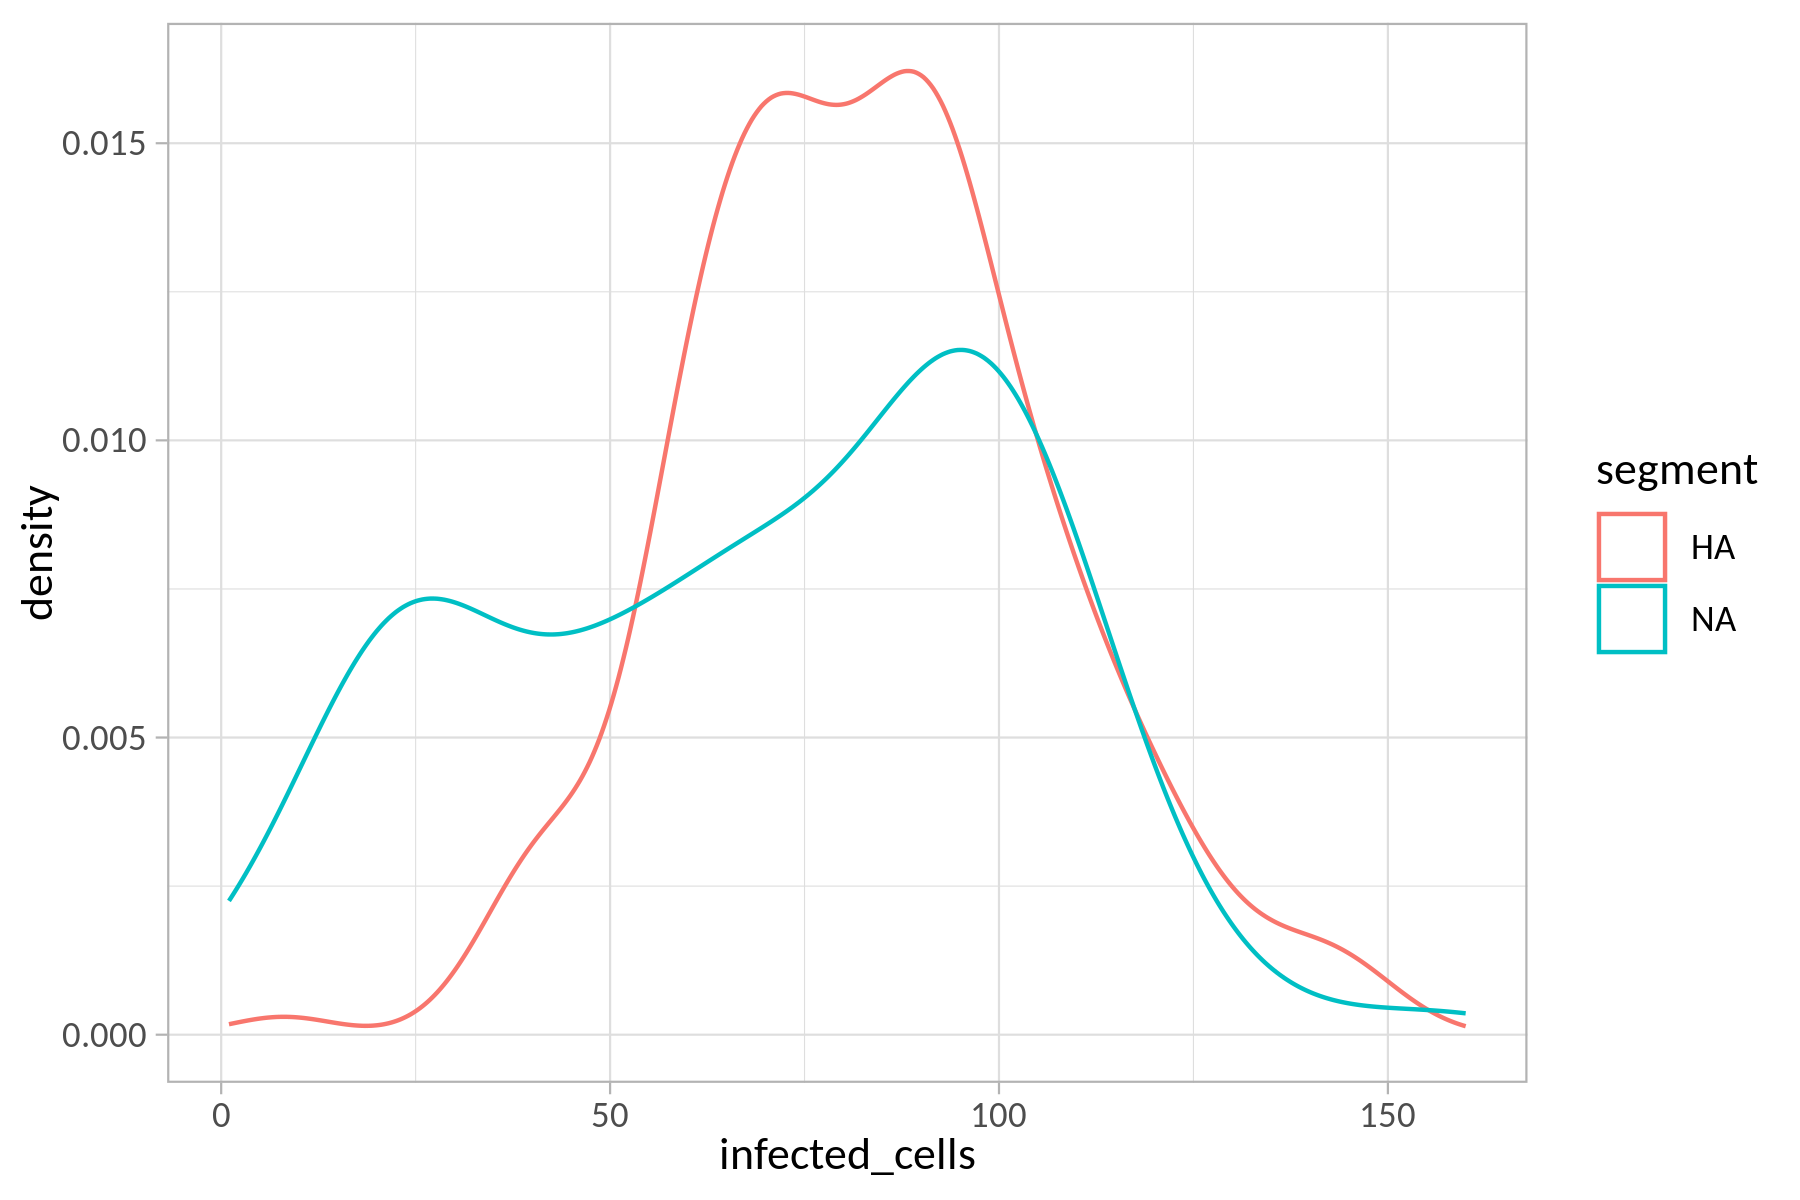

In [10]:
pos_spots_summary %>% ggplot(aes(x=infected_cells, color=segment)) + geom_density()

### <a id='toc1_2_4_'></a>[QC spot count outliers (failed segmentation):](#toc0_)

In some cases of the PLP count sensitivity experiment the segmentation failed and very few nuclei were detected, therefore the spots/cell count is massively inflated, there. This problem does not seem to exist here.

In [11]:
pos_spots_summary %>% filter(spots_per_infected_cell>1000)

rep,segment,sample,fov,infected_cells,spots,median_intensity,mean_radius,spots_per_infected_cell
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>


## <a id='toc1_3_'></a>[Spots per (infected) cell](#toc0_)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


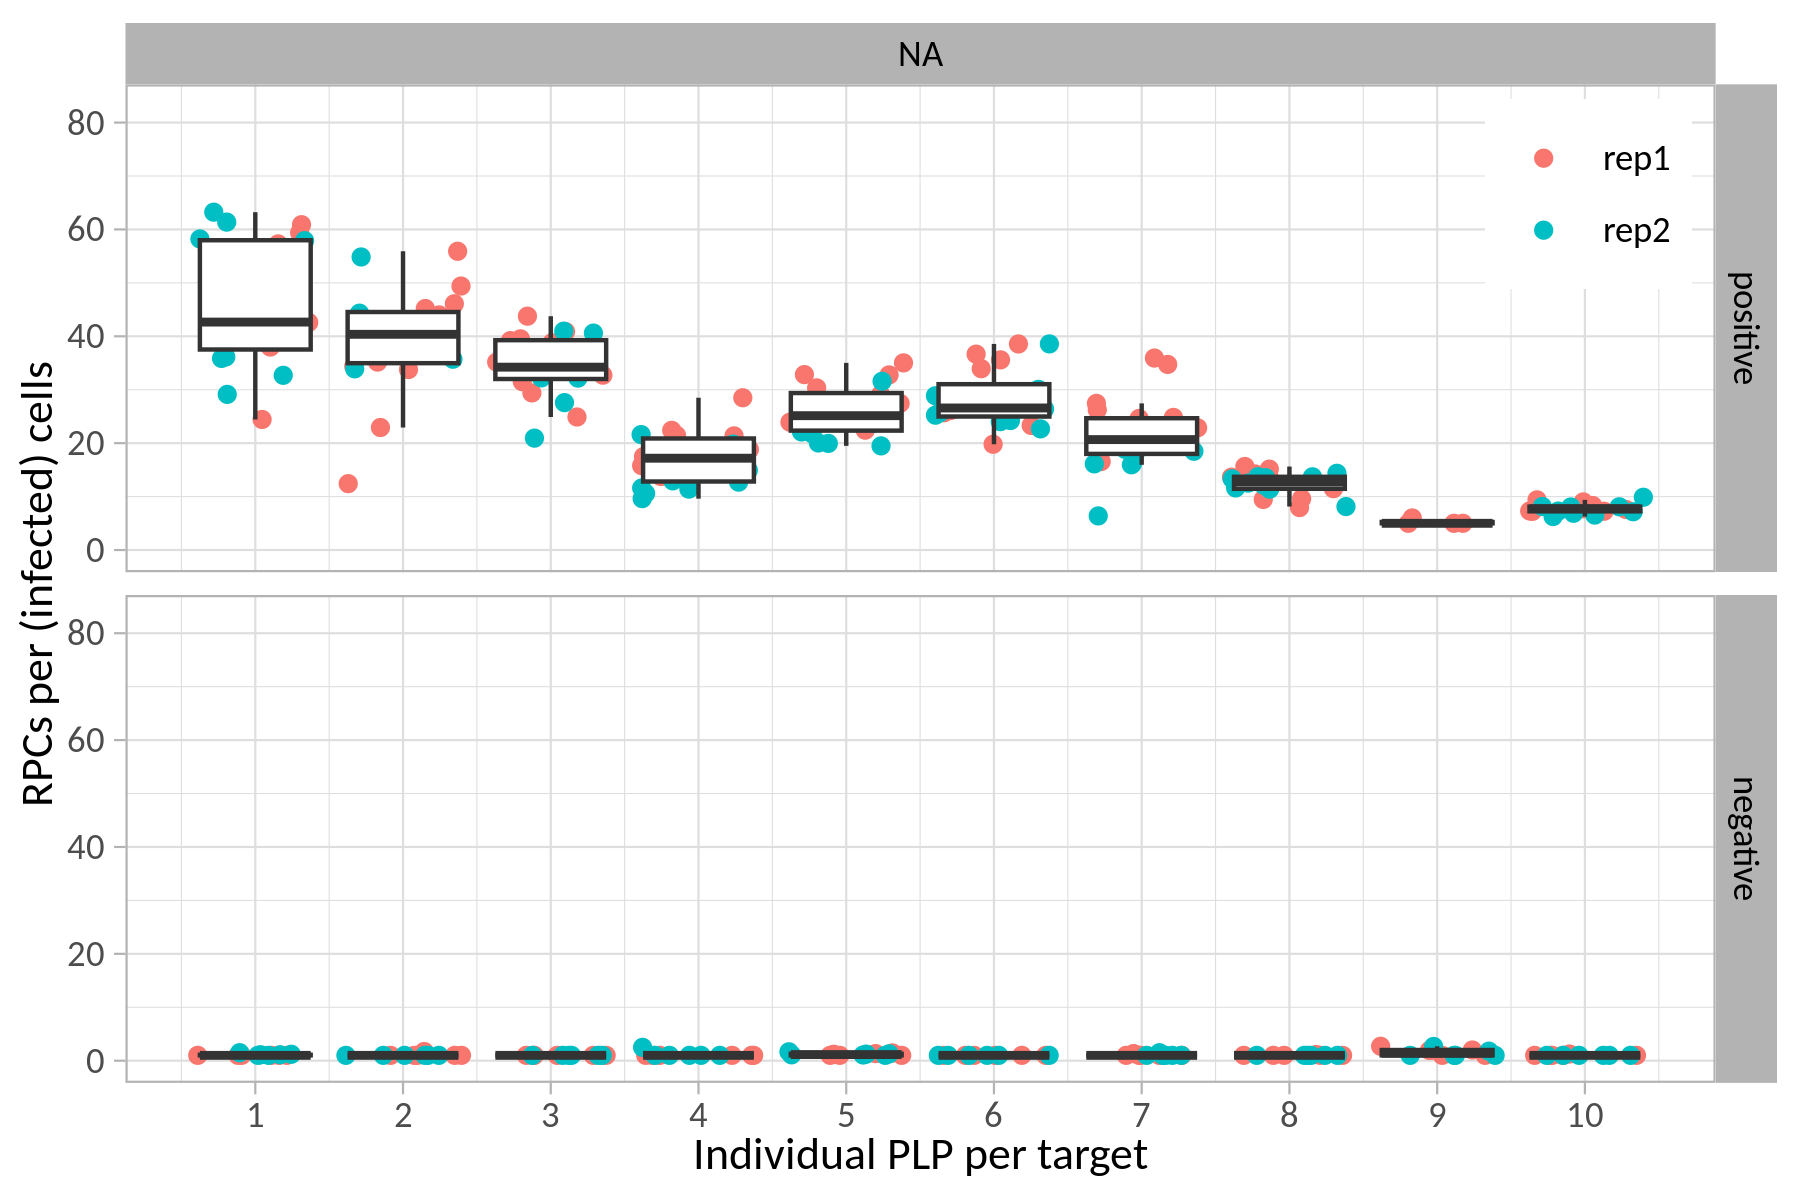

In [12]:
spots_summary %>%
	filter(segment=="NA") %>%
	mutate(plp = parse_number(sample)) %T>%
  write_tsv("figures/fig2cd-plp_individual-spot_counts_NA.tsv") %>%
	ggplot(aes(plp,spots_per_cell))+
		geom_jitter(aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		facet_grid(sample_type ~ segment) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		xlab("Individual PLP per target") +
		ylab("RPCs per (infected) cells") +
		theme(legend.position = c(.92,.89), legend.title = element_blank()) +
		theme(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black')) +
		ylim(0,83) +
		NULL

In [13]:
ggsave("figures/fig2cd-plp_individual-spot_counts_NA.svg", width = 6, height = 4, dpi = 300)

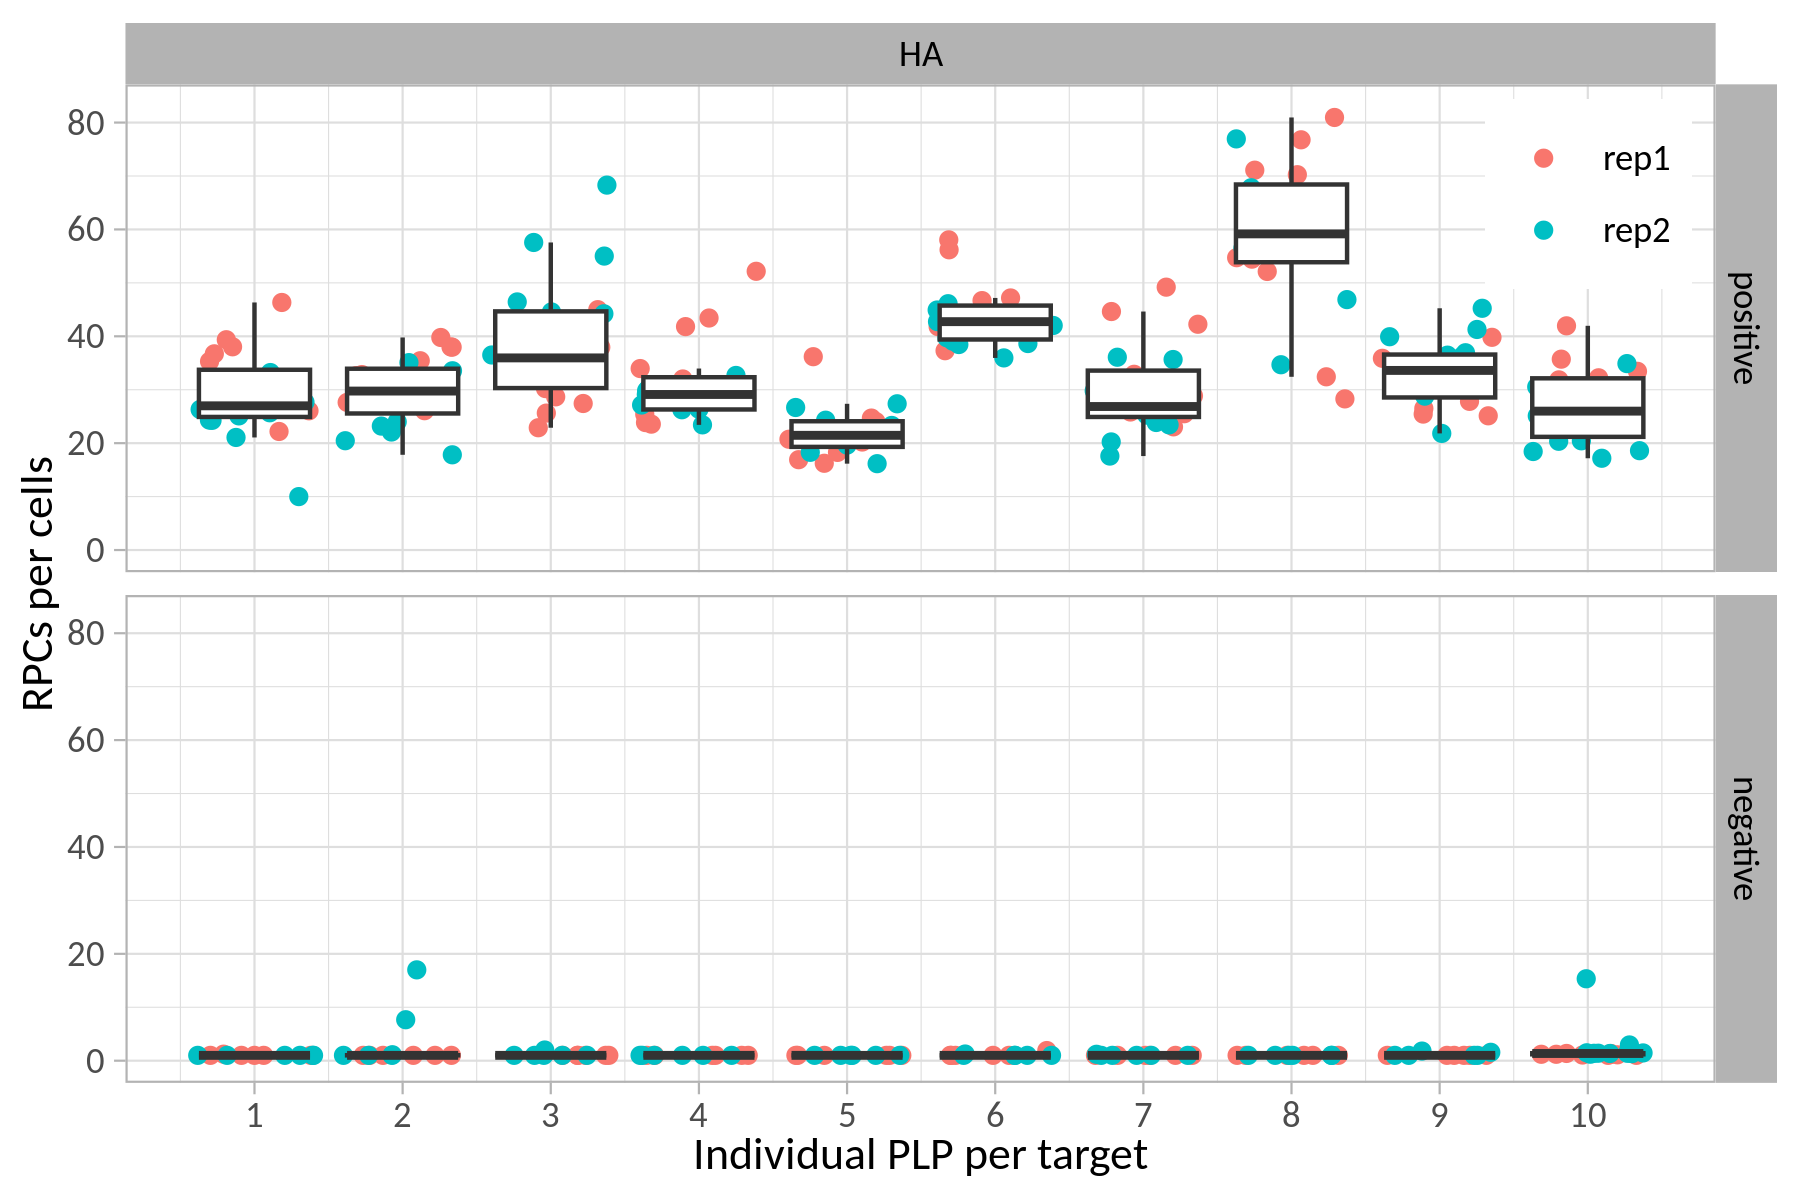

In [14]:
spots_summary %>%
	filter(segment=="HA") %>%
	mutate(plp = parse_number(sample)) %T>%
  write_tsv("figures/supp-fig2cd-plp_individual-spot_counts_HA.tsv") %>%
	ggplot(aes(plp,spots_per_cell))+
		geom_jitter(aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		facet_grid(sample_type ~ segment) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		xlab("Individual PLP per target") +
		ylab("RPCs per cells") +
		theme(legend.position = c(.92,.89), legend.title = element_blank()) +
		ylim(0,83) +
		theme(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black')) +
		NULL

In [15]:
ggsave("figures/supp-fig2cd-plp_individual-spot_counts_HA.svg", width = 6, height = 4, dpi = 300)

In [16]:
for(segment in c("NA", "HA")) {
  supp = ""
  if (segment == "HA") {
    supp = "supp-"
  }
  read_tsv(str_glue("figures/{supp}fig2cd-plp_individual-spot_counts_{segment}.tsv")) %>%
    group_by(segment, plp, sample_type) %>%
    summarize(
      q25=quantile(spots_per_cell, probs=c(0.25)),
      median = median(spots_per_cell),
      q75=quantile(spots_per_cell, probs=c(0.75)),
      mean = mean(spots_per_cell),
      sd = sd(spots_per_cell),
      n_fovs = n(),
    ) %>%
    write_tsv(str_glue("figures/{supp}fig2cd-plp_individual-spot_counts_{segment}-summary.tsv"))
}

Rows: 302 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rep, sample, fov, sample_type
dbl (6): n_cells, spots, median_intensity, mean_radius, spots_per_cell, plp
lgl (1): segment

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'segment', 'plp'. You can override using
the `.groups` argument.
Rows: 324 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): rep, segment, sample, fov, sample_type
dbl (6): n_cells, spots, median_intensity, mean_radius, spots_per_cell, plp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'segment', 'plp'. You can override using
the `.groups` argu

### <a id='toc1_3_1_'></a>[QC consistency across replicates](#toc0_)

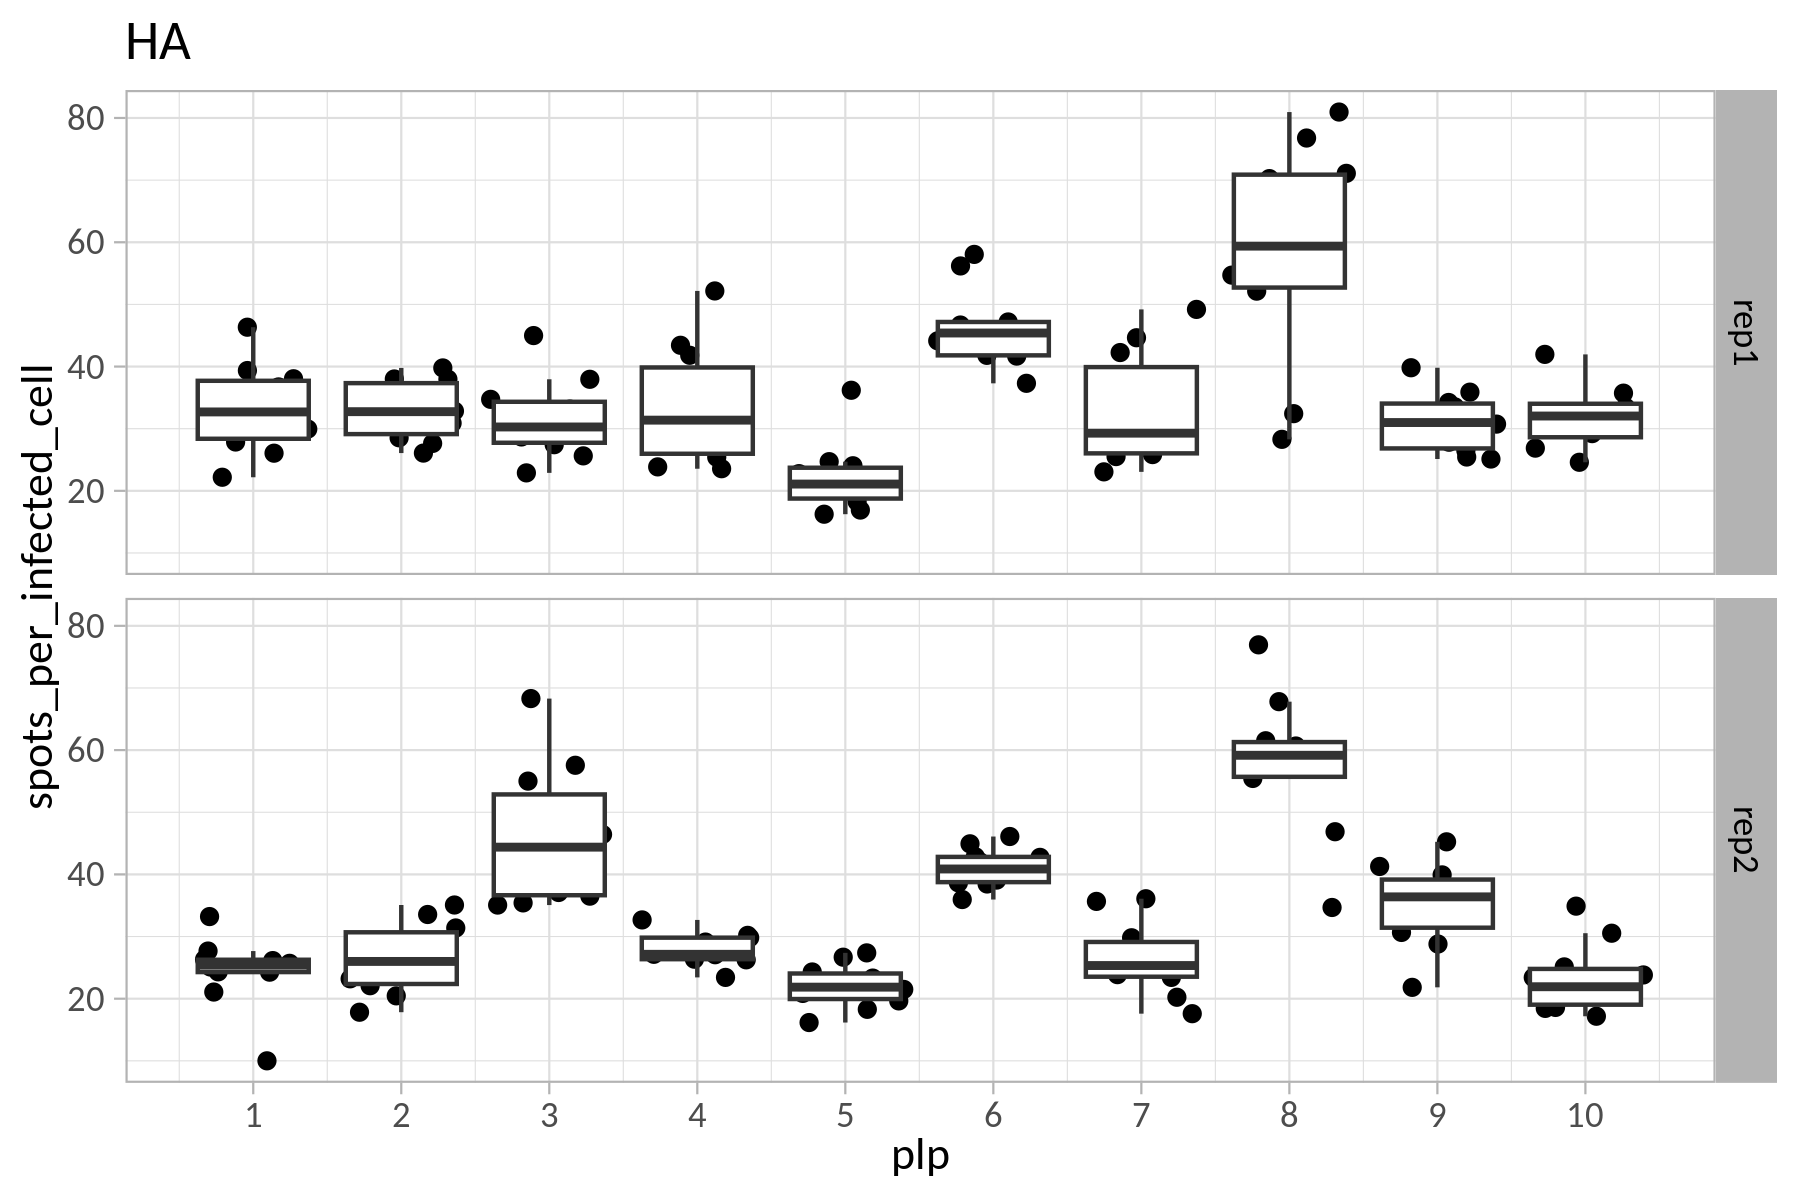

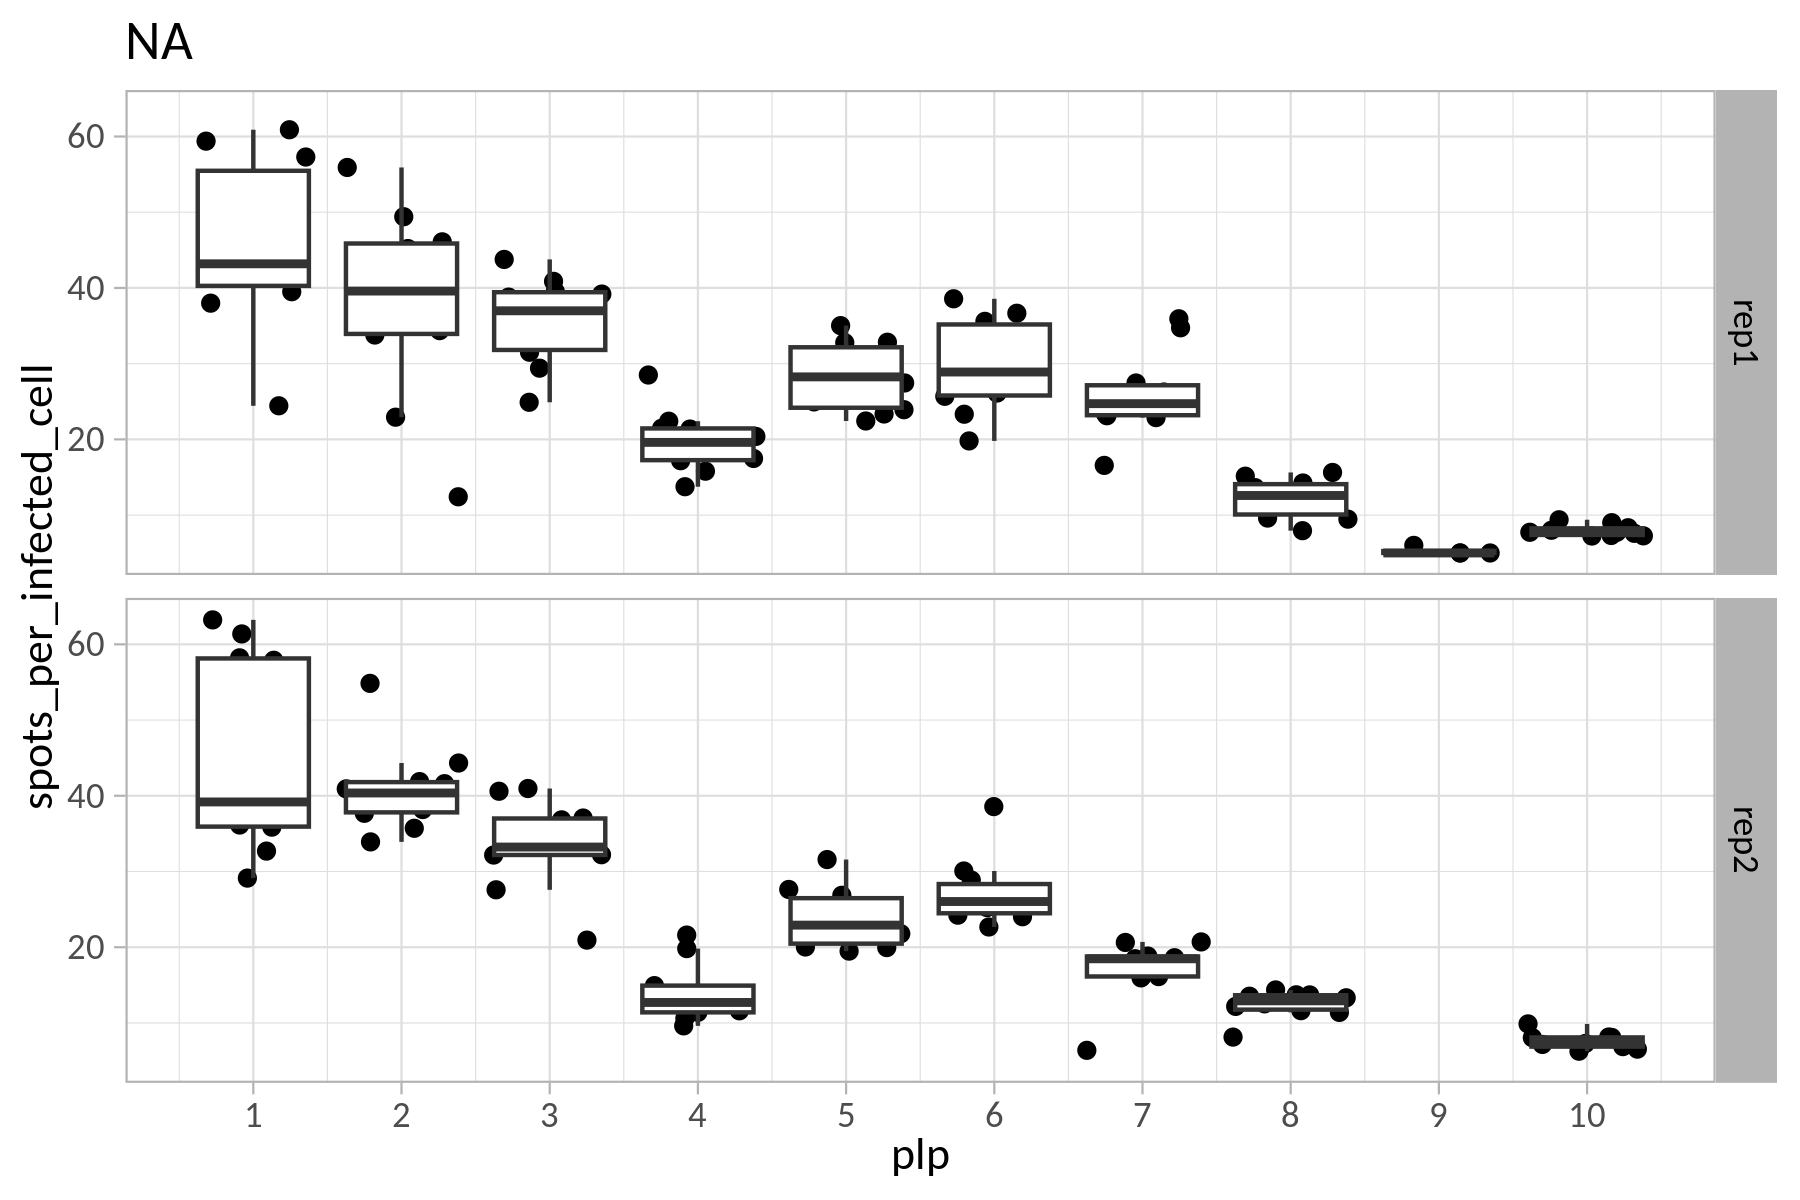

In [17]:
for(s in c("HA","NA")){
	print(pos_spots_summary %>%
		filter(segment==s) %>%
		mutate(sample=str_replace(sample,"NegCtrl","0"), plp = parse_number(sample)) %>%
		ggplot(aes(plp,spots_per_infected_cell)) +
			geom_jitter()+
			geom_boxplot(aes(group=plp), outlier.shape = NA) +
			facet_grid(rep ~ .) +
			ggtitle(s) +
			scale_x_continuous(breaks = seq(1, 10, by = 1)) +
			NULL)
}

## <a id='toc1_4_'></a>[Median spot intensity](#toc0_)

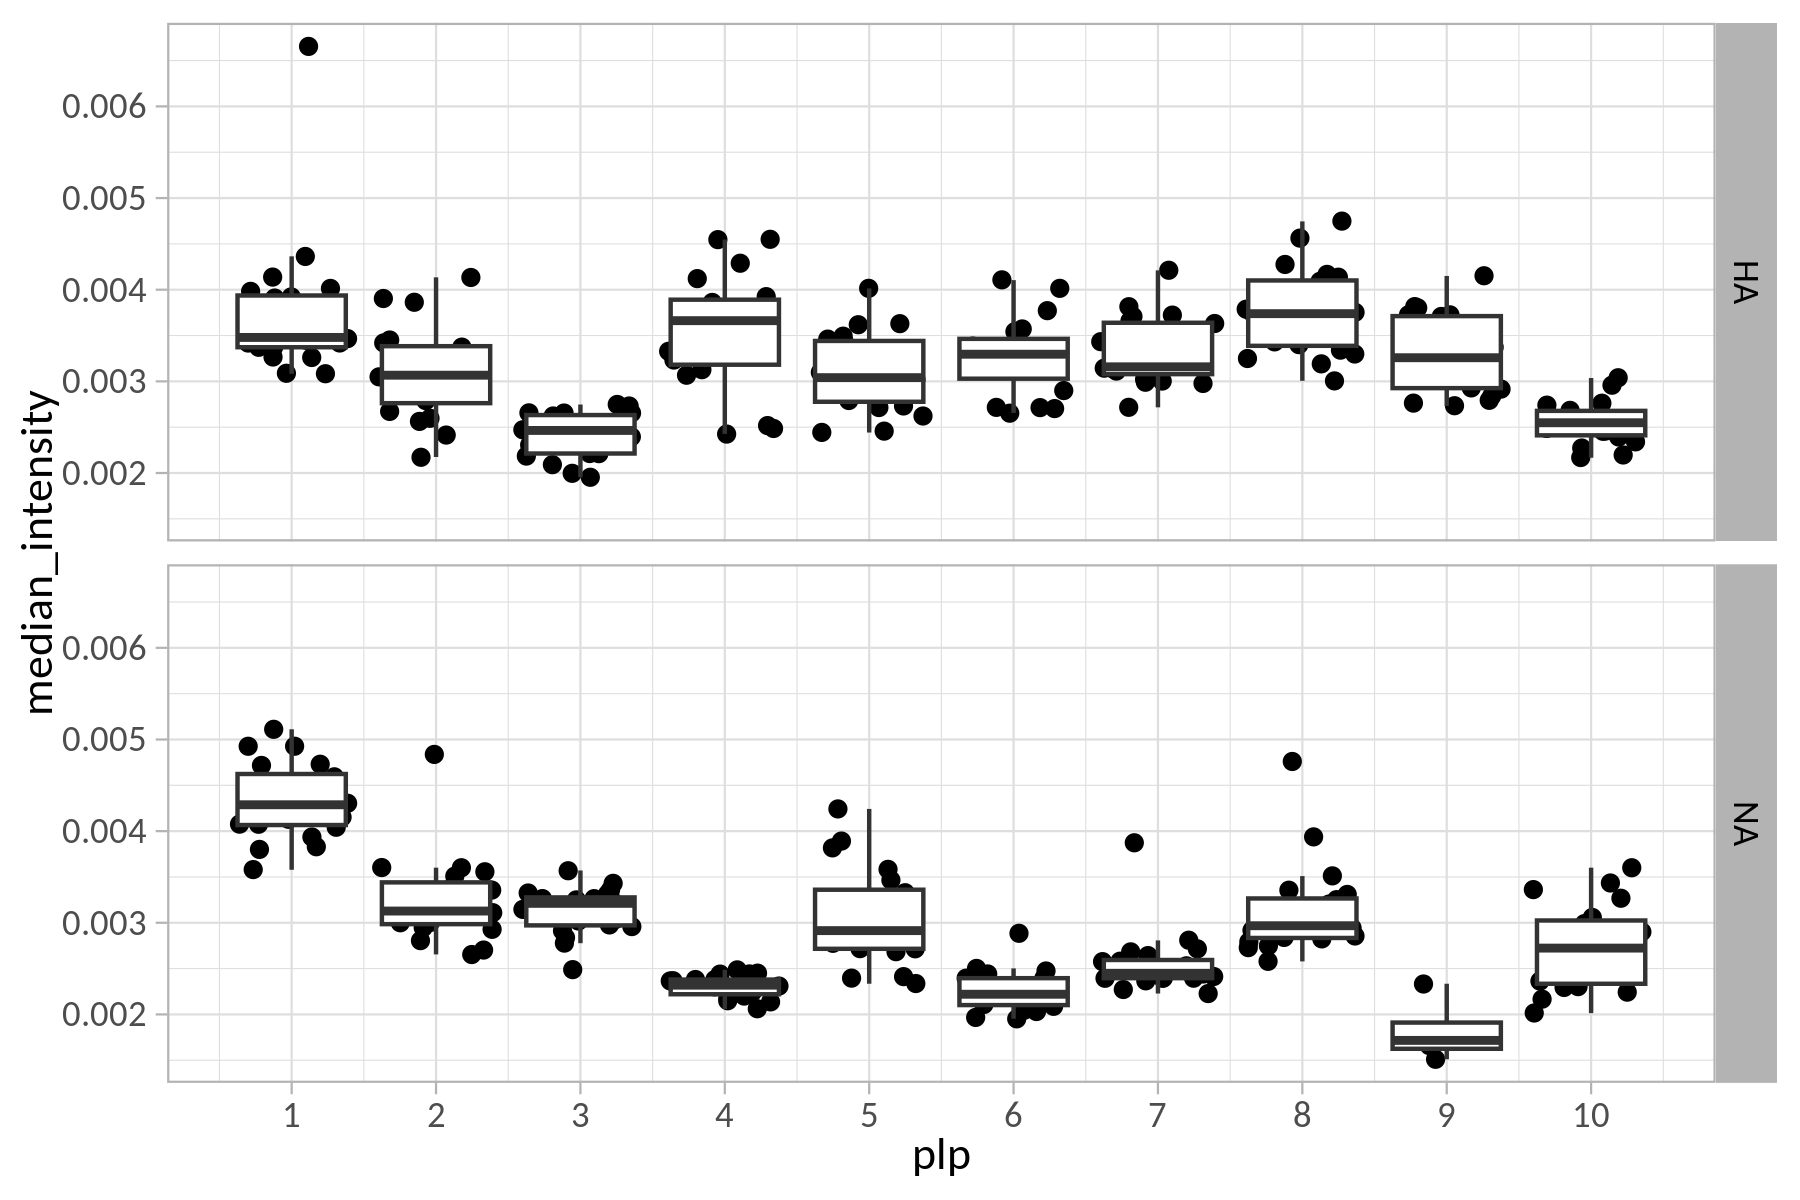

In [18]:
pos_spots_summary %>%
	mutate(plp = parse_number(sample)) %>%
	ggplot(aes(plp,median_intensity)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=plp), outlier.shape = NA) +
		facet_grid(segment ~ .) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		NULL

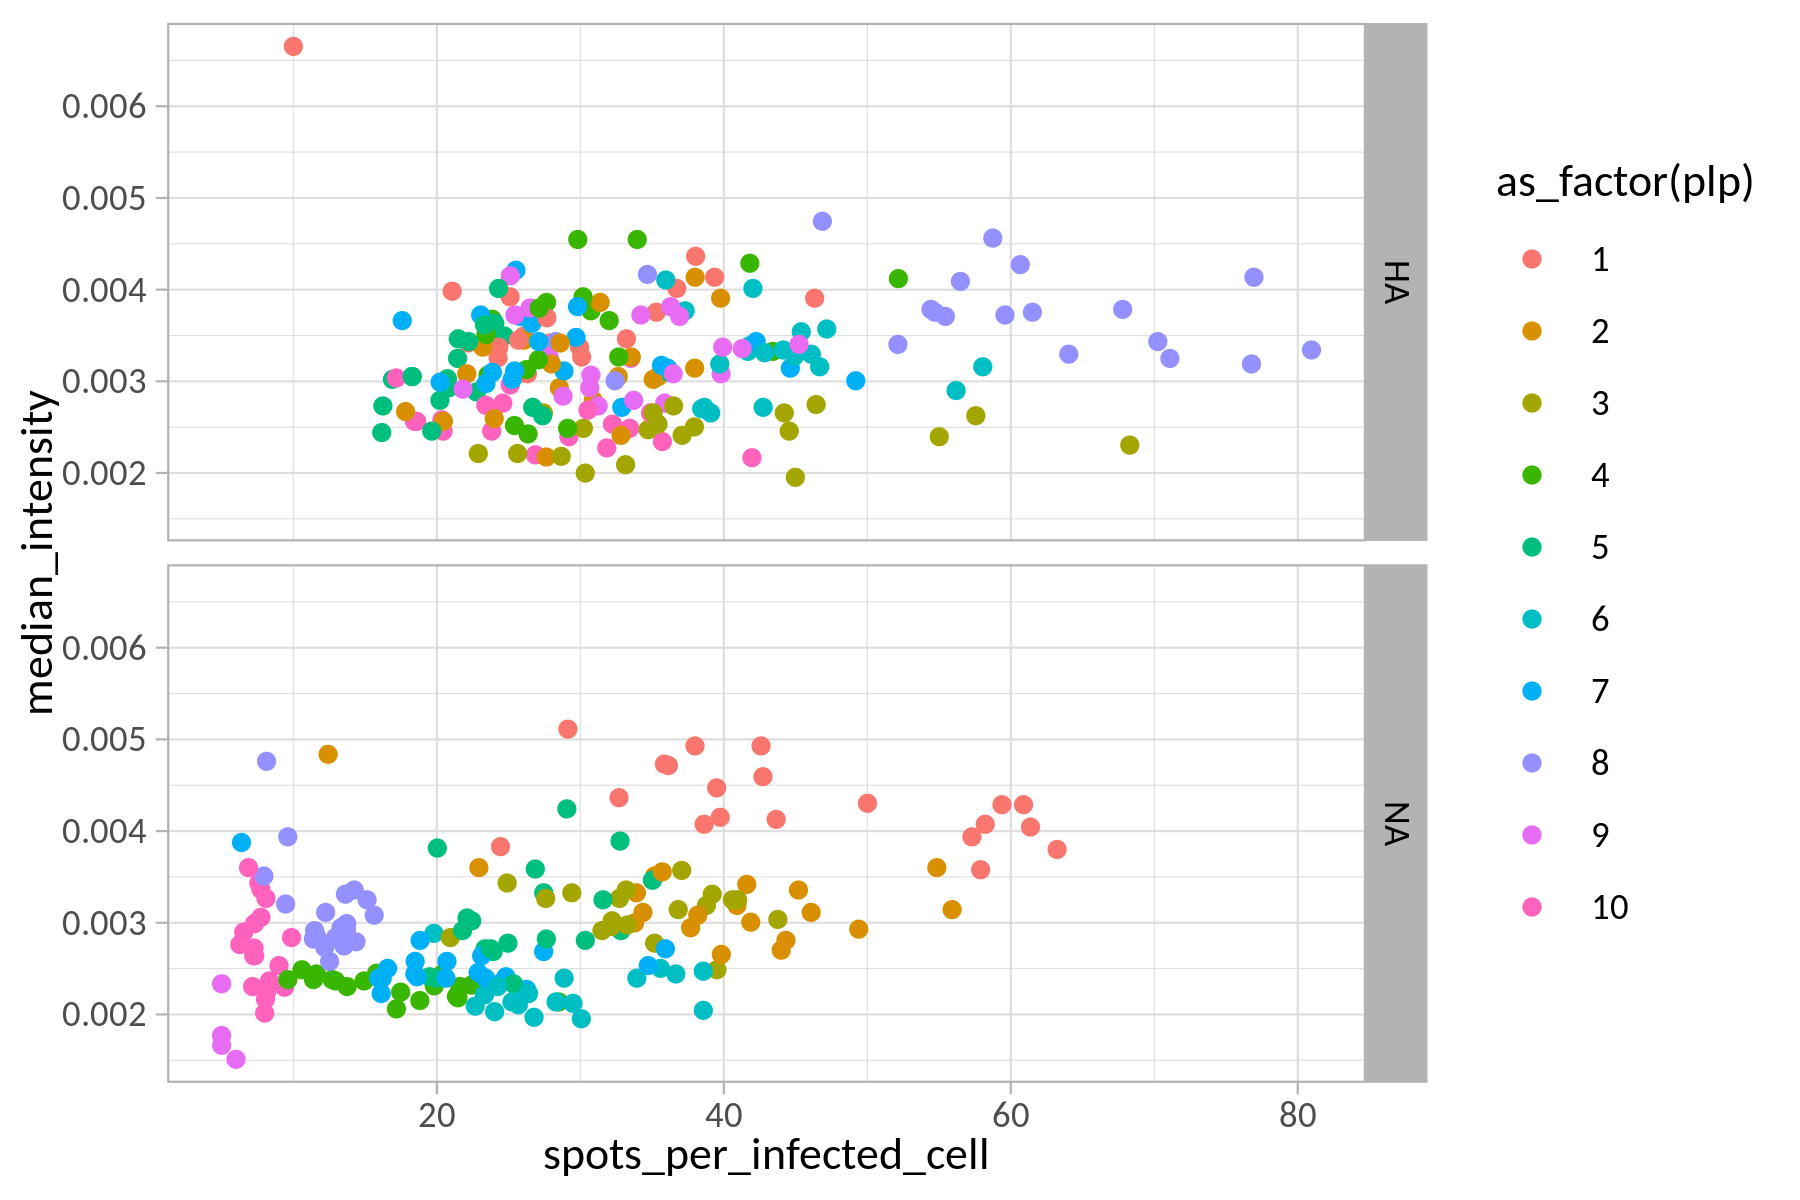

In [19]:
pos_spots_summary %>%
	mutate(plp = parse_number(sample)) %>%
	ggplot(aes(spots_per_infected_cell, median_intensity, color=as_factor(plp))) +
		geom_point() +
		facet_grid(segment ~ .) +
		NULL

No apparent correlation between number of spots per infected cell and median spot intensity.